In [4]:
import logging, os
import sys

NETWORK = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
STEPS = 150
FPS = 30
FREEZE_STEPS = 30

BASE_PATH = "../../../../local_data/jheaton/"
DATA_PATH = "../../../../local_data/tfds/"
PACKAGES_PATH="../../../../local_data/packages/"
SHAPE_PRED_PATH="../../../../local_data/packages/shape_predictor/"
OUTPUT_PATH = BASE_PATH+"class_09_4_facial_points/"
os.system("mkdir -p " + OUTPUT_PATH)

sys.path.insert(0, PACKAGES_PATH+"stylegan2-ada-pytorch")

SOURCE_NAME= OUTPUT_PATH+"about-jeff-heaton-2020.jpg"
TARGET_NAME= OUTPUT_PATH+"thor.jpg"


In [6]:
import cv2
import numpy as np
from PIL import Image
import dlib
from matplotlib import pyplot as plt
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(SHAPE_PRED_PATH+'shape_predictor_5_face_landmarks.dat')

In [8]:
img = cv2.imread(SOURCE_NAME)
if img is None:
    raise ValueError("Source image not found")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 0)

if len(rects) == 0:
    raise ValueError("No faces detected")
elif len(rects) > 1:
    raise ValueError("Multiple faces detected")

shape = predictor(gray, rects[0])

w = img.shape[0]//50

for i in range(0, 5):
    pt1 = (shape.part(i).x, shape.part(i).y)
    pt2 = (shape.part(i).x+w, shape.part(i).y+w)
    cv2.rectangle(img,pt1,pt2,(0,255,255),4)
    print(pt1,pt2)

(364, 183) (374, 193)
(330, 185) (340, 195)
(244, 185) (254, 195)
(277, 185) (287, 195)
(306, 244) (316, 254)


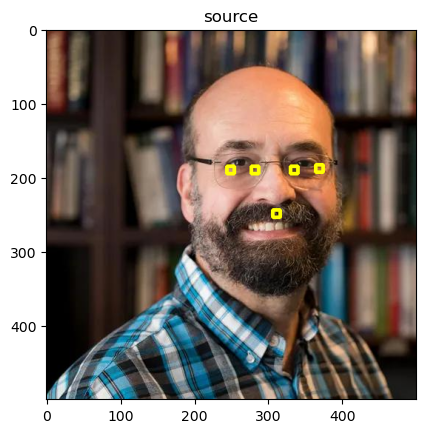

In [9]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()